![meme](https://i.imgflip.com/6x0g1f.jpg)

# Optimizing fantasy basketball

Fantasy basketball is an extremely popular pasttime for nba fans. Participants 'draft' players before the season, then get rewarded for their proxys' in-game performances during the season. 

There are three commonly played standard formats. As described by [ESPN](https://support.espn.com/hc/en-us/articles/360003913632-Scoring-Formats), they are

>Rotisserie: Rotisserie, or "Roto," is the most common way to play fantasy basketball. In this scoring type, teams are ranked from first to last in each statistical category. Points are then awarded according to the order in each category and totaled to determine an overall score and league rank.

>Head-to-Head: Each Category: H2H Each Category is the most common type of head-to-head play in fantasy basketball. It allows you to select the "X" number of statistic categories. For each scoring period, team totals are accumulated and a win, loss or tie is credited in each category based on the matchup results (i.e. 6-3-1 in a 10 category league). If selected, your league will have team schedules/playoffs and you will have the option to set up divisions.

>Head-to-Head: Most Categories: H2H Most Categories allows you to set "X" number of statistic categories. For each scoring period (usually Monday through Sunday) team totals are accumulated in each of the categories. At the end of the scoring period, the winner is determined by which team wins the most number of categories. The end result is a win (1-0-0), loss (0-1-0) or tie (0-0-1). These results correspond directly to each team's overall record. If selected, your league will have team schedules/playoffs and you will have the option to set up divisions.

Common settings specify 9 categories: points, rebounds, assists, steals, blocks, 3-pointers, field goal %, free throw %, and turnovers. Participants are paired up to compete week-by-week, and at the end of the season, the player with the best record wins.

One might note that from a mathematical perspective the first two formats are very similar. In Rotisserie, if you perform better in a category than five other teams and worse than six, you get five points. That is the same reward that you would get if you faced them individually and got points for winning the category. The rotisserie format has less variance because you are effectively facing everyone in one week instead of spread out over several weeks, allowing more total data points. But the mathematical objective remains the same: maximizing the expected number of wins across all categories and opponents. For our purposes, we will therefore only look at H2H and the winner-take-all version, assuming that the H2H strategy will also work for Rotisserie

Understanding the game of basketball helps win fantasy drafts. However, it's not the whole ballgame: even if we had precise probability distributions for player performance beforehand, or exact numbers with no uncertainty, it would not be obvious how to draft correctly. Do we want to optimize for all nine categories, or just some of them? Do we try to compete on the categories that other drafters are going for, or ones they are not? Do we embrace high-volatility players or low-volatility players? The problem becomes a rich mathematical one, more familiar to data scientists than to basketball enthusiasts

There is plenty of speculation about all this within the fantasy basketball community. However, few in the community realize that their strategies are leveraging high-level mathematical intuition. If we lean into the math, and treat this as an optimization problem, can we derive a method for fantasy drafting that delivers consistently high performance?

Our approach will be to break down the drafting problem into three mathematical steps
- Part one (this notebook): Retrospectively drafting a full previous season, with full knowledge of player performance. Weekly totals will be randomly sampled from actual weekly totals for each player. Fantasy drafting this way becomes a full-information game, and therefore at least one Nash equilibrium exists. However, since in practice the vast majority of players are using approximate strategies rather than attempting to be optimal, we will instead look for strategies that beat common naive strategies
- Part two: Using predictive data science methods to make estimates of future performance
- Part three: Plug in the results from part two into the algorithms of part one in order to create a drafting strategy that will theoretically work well for real fantasy drafts 

One other note, before we get started on part one:

NBA fantasy drafts require participants to play with a certain number of players at each position, e.g. three centers, plus a few players on the bench who do not count. I've personally found in my (albeit limited) experience that usually I can have all of my players and games count by shifting players to the bench when they are not playing. This would not be the case if my team was totally imbalanced and for example had no centers, but otherwise I think it is a fair assumption. Therefore I will simplify the problem in the following way: 

- Each team must have 3 centers, 1 point guard, 1 shooting guard, 2 guards (either PG or SG), 1 small forward, 1 power forward, 2 forwards (either SF or PF), and 3 utilities (any positions)
- Every game played by all of your players count towards your totals

# Retrospective drafting

Let's lay out the infrastructure for the first step, retrospective drafting

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from itertools import combinations
from collections import Counter
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import copy
import cvxpy
from unidecode import unidecode

from src.drafting_agents import ZAgent, ZPlusAgent, GOAgent
from src.simulation import run_draft, run_multiple_seasons
from src.helper_functions import check_team_eligibility

pd.set_option('display.max_rows', 150)
pd.options.mode.chained_assignment = None  # default='warn'

categories = ['pts', 'trb', 'ast', 'stl', 'blk', 'fg3','tov', 'fg_pct','ft_pct']

We will use the raw data from [Advanced Sports Analytics](https://www.advancedsportsanalytics.com/nba-raw-data), which has game-by-game player statistics

In [24]:
stat_df = pd.read_csv('../data/ASA All NBA Raw Data (1).csv')
essential_info = stat_df[['player','game_date','pts','trb','ast','stl','blk','fg3','fg','fga','ft','fta','tov']]
essential_info.head()

,player,game_date,pts,trb,ast,stl,blk,fg3,fg,fga,ft,fta,tov
0,Andrew Wiggins,2020-12-22,13,2,1,0,1,2,4,16,3,4,4
1,Stephen Curry,2020-12-22,20,4,10,2,0,2,7,21,4,4,3
2,Kelly Oubre,2020-12-22,6,7,2,1,2,0,3,14,0,0,3
3,James Wiseman,2020-12-22,19,6,0,2,0,1,7,13,4,8,1
4,Eric Paschall,2020-12-22,6,1,0,0,1,1,2,6,1,2,0


Different platforms define positions in different ways. We will try to do it fairly, by making a player eligible for a position if they spent more than a third of their play time at that position.

In [25]:
player_cat_df = stat_df.groupby('player')[['PG%','SG%','SF%','PF%','C%']].mean()
player_cat_df.columns = ['PG','SG','SF','PF','C']
player_cat_df_melted = player_cat_df.melt(ignore_index = False)
player_cat_df_melted.columns = ['position','play_percent']
positions = player_cat_df_melted[player_cat_df_melted['play_percent'] > 33].groupby('player')['position'].agg(list)
positions.head()

player
Aaron Gordon     [PF]
Aaron Holiday    [PG]
Aaron Nesmith    [SF]
Abdel Nader      [SF]
Adam Mokoka      [SG]
Name: position, dtype: object

The most important infrastructure is code simulating an actual NBA fantasy season, so that we can evaluate the success of our strategies. Actually, since our model is probabilistic, we want to run many seasons and get the average # of wins.

We'll synthesize the 2021 season into weeks of play, and randomly sample from it for the season

In [26]:
essential_info = stat_df[['player','game_date','pts','trb','ast','stl','blk','fg3','fg','fga','ft','fta','tov']]
essential_info['game_date'] = pd.to_datetime(essential_info['game_date'])
essential_info_2021_season = essential_info[(essential_info['game_date'] >= '2021-10-19') &  \
                                            (essential_info['game_date'] <= '2022-4-10')]
essential_info_2021_season['week'] = essential_info['game_date'].dt.isocalendar()['week']

weekly_df_index = pd.MultiIndex.from_product([pd.unique(essential_info_2021_season['player'])
                                             ,pd.unique(essential_info_2021_season['week'])]
                                             ,names = ['player','week'])
weekly_df_2021_season = essential_info_2021_season.drop(columns = ['game_date']).groupby(['player','week']).sum()
season_df = pd.DataFrame(weekly_df_2021_season, index = weekly_df_index ).fillna(0)

In [28]:
season_df

pts  trb  ast  stl  blk  fg3   fg  fga   ft  fta  tov
player week                                                       
NaN    52    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
       53    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
       1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
       2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
       3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
       4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
       5     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
       6     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
       7     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
       8     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
       9     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
       10    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
       11    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
       12    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
       13    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
       14    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
       15    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
       16    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
       17    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
       18    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
       19    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
       20    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
       21    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
       22    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
       23    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
       24    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
       25    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
       26    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
       27    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
       28    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
       29    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [20]:
essential_info[essential_info['game_date'] <= '2022-4-10']

,player,game_date,pts,trb,ast,stl,blk,fg3,fg,fga,ft,fta,tov
3507,Andrew Wiggins,2020-12-22,13,2,1,0,1,2,4,16,3,4,4
3508,Stephen Curry,2020-12-22,20,4,10,2,0,2,7,21,4,4,3
3509,Kelly Oubre,2020-12-22,6,7,2,1,2,0,3,14,0,0,3
3510,James Wiseman,2020-12-22,19,6,0,2,0,1,7,13,4,8,1
3511,Eric Paschall,2020-12-22,6,1,0,0,1,1,2,6,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
93001,Andrew Wiggins,2020-03-07,10,4,4,1,1,0,3,10,4,7,1
93002,Juan Toscano-Anderson,2020-03-07,6,6,2,0,0,0,3,6,0,0,0
93003,Dragan Bender,2020-03-07,10,3,1,0,0,2,4,4,0,0,0
93004,Mychal Mulder,2020-03-07,18,1,3,0,0,3,5,10,5,6,0


We've imported a function that simulates multiple seasons, based on the dataframe with statistics from the 2021 season

In [5]:
print(run_multiple_seasons.__doc__)

Simulate multiple seasons with the same drafters 
    
    Weekly performances are sampled from a dataframe of real season performance
    Teams win weeks by winning more categories than their opponents. They win seasons by winning the
    most weeks of all players 
    
    Args:
        teams: player assignment dict, as produced by the run_draft() functoin
        season_df: dataframe of weekly numbers per players. These will be sampled to simulate seasons
        n_seasons: number of seasons to simulate
        n_weeks: number of weeks per season
        winner_take_all: If True, the winner of a majority of categories in a week gets a point.
                         If false, each player gets a point for each category won 
        
    Returns:
        Series of winning percentages with the structure
         team_number : winning_percent  
    


We also imported a function that simulates the drafting process, with agents that pick players based on rules. Drafts are typically run in the snake format. We'll consider a single round to be the back and forth of the snake- so for example with three drafters, player one picks, player two picks, player three picks two players, player two picks, and player one picks

In [6]:
print(run_draft.__doc__)

Run a snake draft

    Snake drafts wrap around like 1 -> 2 -> 3 -> 3 -> 2 -> 1 -> 1 -> 2 -> 3 etc. 
    
    Args:
        agents: list of Agents, which are required to have make_pick() methods
        n_rounds: number of rounds to do of the snake draft. Each drafter will get n_rounds * 2 players
        
    Returns:
        dictionary of player assignments with the structure
         {'player name' : team_number } 
    


 A simple drafter will use player stat totals, so we will create a table for them

In [7]:
player_averages = season_df.reset_index().drop(columns= 'week').groupby('player').mean()
player_averages['fg_pct'] = (player_averages['fg']/player_averages['fga']).fillna(0)
player_averages['ft_pct'] = (player_averages['ft']/player_averages['fta']).fillna(0)
player_averages = player_averages[categories]

When we test a strategy, we want to see if it works broadly, not just in any one position. So we will create a helper function that tries a strategy in each position against some default agent in all the other positions

In [8]:
def try_strategy(primary_agent, default_agent, n_seasons, winner_take_all = True):

    strategy_res = [[] for i in range(12)]
    for i in range(12):
        #we need to deepcopy the agents so that they don't share references with each other
        agents = [copy.deepcopy(default_agent) for x in range(i)] + \
                    [copy.deepcopy(primary_agent)] + \
                    [copy.deepcopy(default_agent) for x in range(11-i)]
        
        teams = run_draft(agents ,7)
        res = run_multiple_seasons(teams = teams
                                   , season_df = season_df
                                   , categories = categories
                                   ,n_seasons = n_seasons
                                   ,winner_take_all = winner_take_all)
        strategy_res[i] = (res.get(i)) if (res.get(i)) is not None else 0 
        
    return np.sum(strategy_res)/(12*n_seasons)


One last bit of infrastructure worth mentioning is a function to check if a team is valid, based on its players' positions. We will use it to validate whether we can add a particular player to an existing team. Surprisingly, this is not a trivial problem. 

Many players can slot into multiple positions, which makes it complicated to determine which positions are still open and which are not. The most elegant way to solve the problem is to model it as a 'phase one' optimization problem, whereby we  model the constraints with an extra variable 'z' loosening the constraints, and aim to minimize z. Fortunately we don't have to set that up manually- optimization software will do it automatically if we set up the optimization problem as is and give a dummy objective of zero. 

ZR: Put in formulation of the feasibility question

One might argue that our model needs to be an integer program to handle its' decision variables. This would not be ideal, since integer programs are much slower than linear programs.  Luckily we don't need to worry about that; the problem is an assignment problem and therefore the results will be integers. 

The function that checks for feasibility is a helper function used by the drafting Agents to make sure they are choosing players that fit their team. The docstring is printed below

In [9]:
print(check_team_eligibility.__doc__)

Checks if a team is eligible or not, based on the players' possible positions

    The function works by setting up an optimization problem for assigning players to team positions
    If the optimization problem is infeasible, the team is not eligible
    
    Args:
        players:Lists of players, which are themselves lists of eligible positions. E.g. 
                [['SF','PF'],['C'],['SF']]

    Returns:
        True or False, depending on if the team is found to be eligible or not

    


## 1a. Z-scores

Fantasy rankings are often made by summing players' Z-scores (this means exactly the same thing as it does in statistics, the # of standard deviations away from the mean) by category. We can use this methodology as a naive baselines for player rankings. Since many real drafters use Z-scores, we can expect that the strategies that work the best against z-scores will do the best in practice. 

Normally, Z-scores are calculated based on the league average. This is slightly odd because most league players never get used in fantasy drafts, and shouldn't influence our way of thinking about relevant players. Perhaps we can improve on the basic Z-score methodology by re-scaling with only the top players. We will call this strategy 'Z+'

In [10]:
start = datetime.now()
primary_agent = ZPlusAgent(player_averages = player_averages
                           ,positions = positions
                           ,n_players = 12*7*2)
default_agent = ZAgent(player_averages = player_averages
                           ,positions = positions)
z_plus_res_wta = try_strategy(primary_agent, default_agent, 1000)
z_plus_res_tot = try_strategy(primary_agent, default_agent, 1000, winner_take_all = False)

print('Winner take all: ' + str(round(z_plus_res_wta*100,1)) + '%')
print('Total categories: ' + str(round(z_plus_res_tot*100,1)) + '%')

print(datetime.now() - start)

ValueError: Found array with 0 sample(s) (shape=(0, 9)) while a minimum of 1 is required by StandardScaler.

For both formats, the Z+ score performs better than the baseline rate of $\frac{1}{12}$, which one would expect by chance. It makes sense that it works particularly well for 'Total categories', since the objective is to maximize overall performance across categories, which the Z+ score gets at nicely. This is a great starting point!

## 1b. Optimization through punting

There is one more common strategy that we should consider: punting. Many fantasy drafters choose to ignore some number of categories in order to improve their performance in the other categories. We will test this to see if it gives our methodology a boost

In [12]:
def try_punting_strategy(punting_cats, n = 500, winner_take_all = True):
    primary_agent = ZPlusAgent(player_averages = player_averages
                               ,positions = positions
                               ,punting_cats = punting_cats
                               ,n_players = 12*7*2)
    default_agent = ZAgent(player_averages = player_averages
                           ,positions = positions
                            ,punting_cats = [])
    res = try_strategy(primary_agent, default_agent, n, winner_take_all = winner_take_all)
    variance = np.sqrt(res*(1-res)/(12 * n))
    return res, variance

In [13]:
start = datetime.now()
punting_results_wta = {cat : try_punting_strategy([cat]) for cat in categories}
punting_results_tot = {cat : try_punting_strategy([cat], winner_take_all = False) for cat in categories}
print(datetime.now() - start)

0:08:04.468735


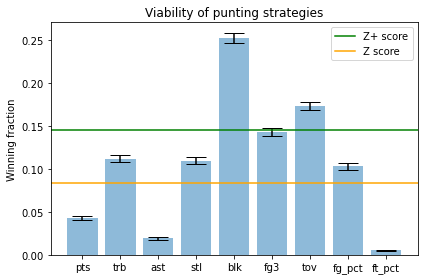

In [16]:
results_unpacked = list(map(list,zip(*[(x[0],x[1][0],x[1][1]) for x in punting_results_wta.items()])))

fig, ax = plt.subplots()

x_pos = np.arange(len(results_unpacked[0]))
ax.bar(x_pos
       , results_unpacked[1]
       , yerr=results_unpacked[2]
       , align='center'
       , alpha=0.5
       , ecolor='black'
       , capsize=10)

ax.set_ylabel('Winning fraction')
ax.set_xticks(x_pos)
ax.set_xticklabels(results_unpacked[0])
ax.set_title('Viability of punting strategies')
ax.axhline(y=z_plus_res_wta, color='green', linestyle='-', label = 'Z+ score')
ax.axhline(y=1/12, color='orange', linestyle='-', label = 'Z score')
plt.legend()

# Save the figure and show
plt.tight_layout()
plt.show()

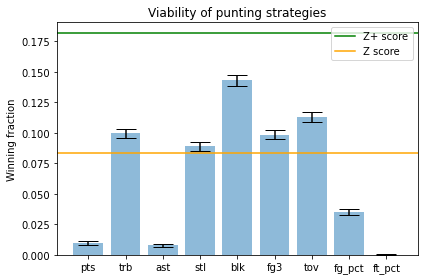

In [15]:
results_unpacked = list(map(list,zip(*[(x[0],x[1][0],x[1][1]) for x in punting_results_tot.items()])))

fig, ax = plt.subplots()

x_pos = np.arange(len(results_unpacked[0]))
ax.bar(x_pos
       , results_unpacked[1]
       , yerr=results_unpacked[2]
       , align='center'
       , alpha=0.5
       , ecolor='black'
       , capsize=10)

ax.set_ylabel('Winning fraction')
ax.set_xticks(x_pos)
ax.set_xticklabels(results_unpacked[0])
ax.set_title('Viability of punting strategies')
ax.axhline(y=z_plus_res_tot, color='green', linestyle='-', label = 'Z+ score')
ax.axhline(y=1/12, color='orange', linestyle='-', label = 'Z score')
plt.legend()

# Save the figure and show
plt.tight_layout()
plt.show()

Matching many drafters' intuitions, punting is a better strategy in winner take all than otherwise. In winner take all, winning ~half of the categories consistently is all that is needed to win every week and maximize points. By contrast, without winner take all, teams will always be punished for losing any category consistently.

Punting blocks in winner-take-all is our best strategy so far. Let's take a look at a team generated by the strategy

In [17]:
primary_agent = ZPlusAgent(player_averages = player_averages
                           ,positions = positions
                           ,punting_cats = ['blk'])
default_agent = ZAgent(player_averages = player_averages
                           ,positions = positions
                       ,punting_cats = [])

i = 6
agents = [copy.deepcopy(default_agent) for x in range(i)] + \
                    [copy.deepcopy(primary_agent)] + \
                    [copy.deepcopy(default_agent) for x in range(11-i)]
        
teams = run_draft(agents ,7)
positions.loc[[k for k,v in teams.items() if v == i]]

player
Trae Young              [PG]
Stephen Curry           [PG]
Darius Garland          [PG]
DeMar DeRozan           [PF]
Jordan Poole            [SG]
Jalen Brunson           [PG]
Monte Morris            [PG]
Harrison Barnes     [SF, PF]
Tyler Herro             [SG]
Deandre Ayton            [C]
Dwight Powell            [C]
Bojan Bogdanovic        [PF]
Javonte Green       [SG, SF]
Onyeka Okongwu           [C]
Name: position, dtype: object

This team heavily leaned into point guards and deprioritized centers. It won't win on blocks often, but it has such a good squad of shooters that it more than compensates with other categories

## 1c. The Gaussian optimizer 

To start designing a more sophisticated algorithm, let's analyze the points we'll score in a category, and the points an opponent will score in the same category. Where $F_{pc}$ is the number of points scored by player $p$ in category $c$, we can write them as 

$$
  \sum_{p \in T_0} F_{pc} \quad , \quad \sum_{p \in T_1} F_{pc}
$$

The point differential between the two is

$$
  \sum_{p \in T_1} F_{pc} +  \sum_{p \in T_0} - F_{pc}
$$

$F_{pc}$ itself is the sum of performances across  three games. With $14$ players per team, the point differential is then the sum of $14*2*3 = 84$ random variables. That is large enough to invoke the law of large numbers, which simplifies the distribution to a normal distribution. Writing $m_{pc}$ as the mean of a player $p$'s category $c$ statistics, and $\sigma_{pc}$ as the corresponding standard deviation, we get it as 

$$
   N(\sum_{p \in T_0} m_{pc} - \sum_{p \in T_1} m_{pc} \: , \: \sum_{p \in T_0} \sigma_{pc}^2 + \sum_{p \in T_1} \sigma_{pc}^2)
$$

The CDF of this normal distribution at zero, which also represents the probability of victory, is 

$$
   \frac{1}{2}[1 + erf(\frac{\sum_{p \in T_0} m_{pc} - \sum_{p \in T_1} m_{pc}}{\sqrt{2 (\sum_{p \in T_1} \sigma_{pc}^2 + \sum_{p \in T_0} \sigma_{pc}^2)}}]
$$

There is one significant wrinkle- free throw percentage and field goal percentage do not work like the other categories, since they are the result of division between two statistics. We can model them a different way. Assuming that each player shoots their average number of shots per game, and their overall percentage is constant throughout the season, then the percentage categories become a sum of binomials (or a Poisson binomial) divided by the number of free throw attempts. The mean of a Poisson binomial is simply the overall weighted mean. The variance of a Poisson binomials is the sum of variance of bernoullis, which can be written as, for example

$$
    \sum_{p \in T} \frac{FT_p}{FTA_p} * (1-\frac{FT_p}{FTA_p}) * FTA_p
$$

or rearranged

$$
    \sum_{p \in T} \frac{FT_p}{FTA_p} * (FTA_p-FT_p)
$$

To get the correct variance for the overall percentage statistic, we need to adjust for the division. Variance changes by the square of a change factor so the result is 

$$
    \frac{ \sum_{p \in T} \frac{FT_p}{FTA_p} * (FTA_p-FT_p)} {(\sum_{p \in T} FTA_p)^2}
$$

This gives us an overall formula for the probability of winning every category. If the format is not winner take all we are done here; the objective is simply to maximize the average category winning probability. 

If the format is winner take all, we need to calculate the probability of winning a majority of categories.  The distribution of the total categories won is a Poisson binomial, with a component binomial for each category parametrized by $n = 1$ and $p = $ probability of winning the category . Unfortunately the Poisson binomial has a CDF involving quite a bit of calculation- there is just no way to simplify the function besides enumerating all possibilities. Fortunately, the number of winning scenarios is only 
$$
    {9 \choose 5} + {9 \choose 6} + {9 \choose 7} + {9 \choose 8}  + {9 \choose 9} = 256
$$

So we can manually check each way of winning the match (for example, winning points/rebounds/assists/steals and losing the others), calculate their probabilities, and add them together.This gives us a formula, albeit a complicated one, to calculate the predicted win probability between two teams. 

We can then pick players with the following process:
1. Define the statistics of a representative opposing team, or multiple opposing teams
2. For each player you could draft, calculate your team's statistics if you chose that player
3. For every possibility from step 2, calculate either the expected number of categories won your probability of winning against the team(s) from part 1, depending on whether you are optimizing for winner takes all or not
4. Choose the player who gives you the best chance of winning

One might argue that the procedure defined above is too greedy because it optimizes winning chances at each step, ignoring players' general value. Ideally we want the optimizer to start by looking at players' general value (total Z+ score), then find players that best fit the team in later rounds. One strategy for this is to make a hybrid score, consisting of both the Gaussian win probability and the Z+ score. Since Z+ scores tend to be larger than win probabilities, we need to include a parameter to de-weight them, which we will call Beta. We can also weigh the Z+ score in a dynamic way, decreasing its importance from 100% to 0% by the last round.

In [18]:
def try_beta_strategy(beta, n = 500, winner_take_all = True):
    primary_agent = GOAgent(season_df = season_df
                             ,player_averages = player_averages
                             ,categories = categories
                             ,positions = positions
                             ,winner_take_all = winner_take_all
                             ,punting_cats = []
                             ,beta = beta)
    default_agent = ZAgent(player_averages = player_averages
                           ,positions = positions
                           ,punting_cats = [])
    res = try_strategy(primary_agent, default_agent, n, winner_take_all = winner_take_all)
    variance = np.sqrt(res*(1-res)/(12 * n))
    return res, variance

start = datetime.now()
beta_results_wta = {beta : try_beta_strategy([beta]) for beta in [0,0.05,0.1,0.15,0.2]}
beta_results_tot = {beta : try_beta_strategy([beta], winner_take_all = False) for beta in [0,0.05,0.1,0.15,0.2]}
print(datetime.now() - start)

0:06:37.469237


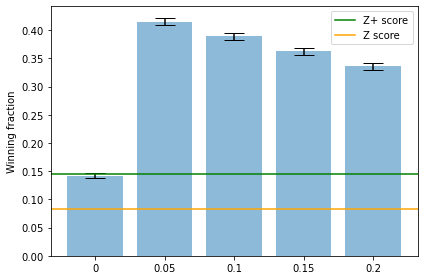

In [19]:
results_unpacked = list(map(list,zip(*[(str(x[0]),x[1][0],x[1][1]) for x in beta_results_wta.items()])))

fig, ax = plt.subplots()

x_pos = np.arange(len(results_unpacked[0]))
ax.bar(x_pos
       , results_unpacked[1]
       , yerr=results_unpacked[2]
       , align='center'
       , alpha=0.5
       , ecolor='black'
       , capsize=10)

ax.set_ylabel('Winning fraction')
ax.set_xticks(x_pos)
ax.set_xticklabels(results_unpacked[0])
ax.axhline(y=z_plus_res_wta, color='green', linestyle='-', label = 'Z+ score')
ax.axhline(y=1/12, color='orange', linestyle='-', label = 'Z score')
plt.legend()

# Save the figure and show
plt.tight_layout()
plt.show()

We can see a local optimum around Beta = 0.05 which is above 40%! That is the best-performing strategy we have found so far, by a long shot

Let's look at a sample team

In [26]:
primary_agent = GOAgent(season_df = season_df
                             ,player_averages = player_averages
                             ,categories = categories
                             ,positions = positions
                             ,punting_cats = []
                            , beta = 0.1)
default_agent = ZAgent(player_averages = player_averages
                        ,positions = positions
                       ,punting_cats = [])

i = 6
agents = [copy.deepcopy(default_agent) for x in range(i)] + \
                    [copy.deepcopy(primary_agent)] + \
                    [copy.deepcopy(default_agent) for x in range(11-i)]
        
teams = run_draft(agents ,7)
positions.loc[[k for k,v in teams.items() if v == i]]

player
Karl-Anthony Towns         [C]
Stephen Curry             [PG]
Mikal Bridges             [SF]
DeMar DeRozan             [PF]
Jordan Poole              [SG]
Domantas Sabonis       [PF, C]
Jalen Brunson             [PG]
Ivica Zubac                [C]
Harrison Barnes       [SF, PF]
Deandre Ayton              [C]
Immanuel Quickley     [PG, SG]
Pat Connaughton           [SF]
Bojan Bogdanovic          [PF]
P.J. Tucker               [PF]
Name: position, dtype: object

This is a well-balanced team, with one player from each position in the first five picks.

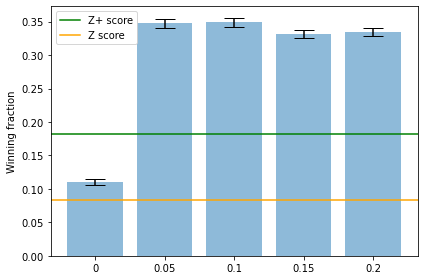

In [20]:
results_unpacked = list(map(list,zip(*[(str(x[0]),x[1][0],x[1][1]) for x in beta_results_tot.items()])))

fig, ax = plt.subplots()

x_pos = np.arange(len(results_unpacked[0]))
ax.bar(x_pos
       , results_unpacked[1]
       , yerr=results_unpacked[2]
       , align='center'
       , alpha=0.5
       , ecolor='black'
       , capsize=10)

ax.set_ylabel('Winning fraction')
ax.set_xticks(x_pos)
ax.set_xticklabels(results_unpacked[0])
ax.axhline(y=z_plus_res_tot, color='green', linestyle='-', label = 'Z+ score')
ax.axhline(y=1/12, color='orange', linestyle='-', label = 'Z score')
plt.legend()

# Save the figure and show
plt.tight_layout()
plt.show()

The Gaussian optimizer strategy also works well without winner take all! 